In [ ]:
import sys
import time
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt

In [ ]:
class Item(object):
    def __init__(self, size):
        self.size  = size  # Valor del item. La suma de los valores de los items es lo que se quiere maximizar

In [ ]:
class Individual:

    def __init__(self, chromosome):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = random.randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]

    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2]

    def mutation_flip(self):
        "Cambia el alelo de un gen escogido aleatoriamente."
        new_chromosome = deepcopy(self.chromosome)
        chromosome_size = len(new_chromosome)
        mutGene = random.randrange(0,len(new_chromosome))   # escoge un gen para mutar
        new_chromosome[mutGene] = random.randint(0,chromosome_size-1)

        return Individual(new_chromosome)

    def mutation_multiflip(self):
        """
        Cambia los alelos de un conjunto de genes escogidos aleatoriamente (hasta un maximo de 50% de genes).
        """
        new_chromosome = deepcopy(self.chromosome)
        chromosome_size = len(new_chromosome)
        # Genera lista de los índices de los genes del cromosoma y los desordena aleatoriamente
        indices = list(range(0, len(new_chromosome)))
        random.shuffle(indices)

        # Máximo de iteraciones: 50%
        gen_mut_porc = 0.5
        max_iter = int( np.floor( len(new_chromosome)*gen_mut_porc ) )

        # Iteración para el cambio del valor de los genes
        for i in range(0, max_iter):
            gen_sel = random.choice(indices)
            indices.remove(gen_sel)
            new_chromosome[gen_sel] = random.randint(0,chromosome_size-1)

        return Individual(new_chromosome)


In [ ]:
def get_fitness(chromosome, items, C, n_bins):
    chromosome = np.array(chromosome)
    fitness = 0
    sum_bin = np.zeros(len(chromosome))
    sum_bin_penalty = 0
    for i in range(len(chromosome)):
        sumbin = 0
        for j in np.where(chromosome == i)[0]:
            sumbin += items[j].size

        bin_exce = sumbin-C
        if  bin_exce > 0:
            sum_bin[i] = 0
            sum_bin_penalty += bin_exce
        else:
            sum_bin[i] = sumbin
    N = len(set(chromosome))
    sum_bin_penalty +=1
    fitness = sum( (sum_bin/C)**2 )/(N*sum_bin_penalty)

    return fitness

In [ ]:
def evaluate_population(population, items, C):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    popsize = len(population)
    for i in range(popsize):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = get_fitness(population[i].chromosome, items, C)

In [ ]:
def init_population(popsize, chromosome_size):
    """Inicializa una poblacion de popsize individuos, cada cromosoma de individuo de tamaño chromosome_size.
       Si zeroes==False La inicializacion es aleatoria (por defecto), si zeroes=True los cromosomas son vectores de ceros"""
    population = []
    for i in range(popsize):
        new_chromosome = [random.randint(0,chromosome_size-1) for j in range(chromosome_size)]
        population.append( Individual(new_chromosome) )
    return population

In [ ]:
def select_parents_roulette(population):
    popsize = len(population)

    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness:
            iParent1 = i
            break

    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre
        cumfitness += population[i].fitness
        if cumfitness > pickfitness:
            iParent2 = i
            break
    return (population[iParent1], population[iParent2])

In [ ]:
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)

    iParent1=np.argmax(list_indiv)

    # Escoje el segundo padre, desconsiderando el primer padre
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)

    return (population[x1[iParent1]],population[x2[iParent2]])

In [ ]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        next_population.append(population[isurvivors[i]])
    return next_population

In [ ]:
def genetic_algorithm(poblacion_inicial, items, ngen=100, pmut=0.1, C=50,
                      crossover="onepoint", mutation="flip",
                      selection_parents_method="roulette",
                      selection_survivors_method="ranking"):

    population = deepcopy(poblacion_inicial)
    popsize = len(population)
    evaluate_population(population, items, C)
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # fitness del mejor individuo
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))

    for g in range(ngen):
        ## SELECCION
        mating_pool = []
        for i in range(int(popsize/2)):
            if selection_parents_method == "roulette":
                mating_pool.append(select_parents_roulette(population))
            elif selection_parents_method == "tournament":
                mating_pool.append(select_parents_tournament(population, 3))
            else:
                raise NotImplementedError
        ## CRUZAMIENTO
        offspring_population = []
        for i in range(len(mating_pool)):
            if crossover == "onepoint":
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut:
                if mutation == "flip":
                    offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
                elif mutation == "inversion":
                    offspring_population[i] = offspring_population[i].mutation_inversion() # invierte todos los genes entre 2 puntos al azar
                elif mutation == "multiflip":
                    offspring_population[i] = offspring_population[i].mutation_multiflip()
                else:
                    raise NotImplementedError

        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, items, C)   # evalua la poblacion descendencia

        ## Selecciona individuos para la sgte. generación
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)

        if (g % 10 == 0):  # muestra resultados cada 10 generaciones
            print("generacion {}, (Mejor fitness = {})".format(g, population[ibest[0]].fitness))

    print("Mejor individuo en la ultima generacion = {} (fitness = {})".format(population[ibest[0]].chromosome, population[ibest[0]].fitness))
    return population[ibest[0]], bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen

CONFIGURACION DE PROBLEMA

In [ ]:
BIN_CAP = 100         # capacidad de bin
NUM_ITEMS = 40        # número de items
MAX_ITEM_SIZE = 50    # máximo tamaño posible de cada item
ItemPool = [ Item(random.randint(1,MAX_ITEM_SIZE)) for x in range (0,NUM_ITEMS)]
itemsize = [ItemPool[i].size for i in range (len(ItemPool))]

num_items = len(itemsize)
max_item = max(itemsize)
print('Número de items:', num_items)
print('Max. tamaño item:', max_item)
print('Items (tamaño):', itemsize)

Número de items: 40
Max. tamaño item: 47
Items (tamaño): [12, 27, 41, 29, 24, 31, 26, 2, 9, 3, 5, 43, 5, 2, 2, 24, 14, 40, 11, 43, 34, 5, 33, 45, 12, 38, 36, 46, 3, 42, 12, 11, 6, 18, 7, 29, 43, 36, 39, 47]


PRUEBA SIN MUTACION (10 ITERACIONES)

In [ ]:
# Hiperparametros fijos del algoritmo genetico
POPSIZE = 50        # numero de individuos
GENERATIONS = 300   # numero de generaciones
PMUT = 0            # taza de mutacion

max_itm_bin = np.floor(BIN_CAP/max(itemsize))
chromo_size = NUM_ITEMS

Tamaño de cromosoma: 20


In [ ]:
import pandas as pd

# Dataframe con las columnas solicitas (media y std del valor de fitness)
df_gen1 = pd.DataFrame(columns=['cruzamiento', 'seleccion', 'fitness', 'gen_conver',
                               'fitness_mean', 'gen_conver_mean'])

# Hiperparametros a evaluar del algoritmo
cruzamiento = ['onepoint', 'uniform']
seleccion = ['roulette', 'tournament']

# Inicializa una población de forma aleatoria
poblacion_inicial =  init_population(POPSIZE, chromo_size)
ejecuciones = 10

i = 0
for xover in cruzamiento:
  for sel in seleccion:
    print('-------------------------------------------------------------')
    print(f'Cruzamiento: {xover}, Selección: {sel}')
    print('-------------------------------------------------------------')
    gen_fitness1 = []
    gen_conver1 = []
    for k in range(0, ejecuciones):
      print('************************')
      print(f'Ejecución: {k+1}')
      print('************************')

      # Evalua la poblacion con el algoritmo genetico
      best_ind1, bestfitness1 = genetic_algorithm(poblacion_inicial, ItemPool,
                                                GENERATIONS, PMUT, BIN_CAP,
                                                crossover=xover,
                                                selection_parents_method = sel)

      # Fitness y generación de convergencia de una ejecución
      max_bestfitness1 = max(bestfitness1)
      min_converge1 = list( ( max_bestfitness1==np.array(bestfitness1) )*1).index(1)+1

      # Lista que almacena el fitness y la generación de convergencia de las 10 ejecuciones
      gen_fitness1.append(max_bestfitness1)
      gen_conver1.append(min_converge1)

    # Actualización de tabla con parámetros evaluados, lista de valores de fitness y de la configuración de convergencia
    # y las medias de ambas
    df_gen1.loc[i,'cruzamiento'] = xover
    df_gen1.loc[i,'seleccion'] = sel
    df_gen1.loc[i,'fitness'] = gen_fitness1
    df_gen1.loc[i,'gen_conver'] = gen_conver1
    df_gen1.loc[i,'fitness_mean'] = np.mean(gen_fitness1)
    df_gen1.loc[i,'gen_conver_mean'] = int(np.mean(gen_conver1))
    i+=1


-------------------------------------------------------------
Cruzamiento: onepoint, Selección: roulette
-------------------------------------------------------------
************************
Ejecución: 1
************************
Poblacion inicial, best_fitness = 0.2019363636363636
generacion 0, (Mejor fitness = 0.20604545454545453)
generacion 10, (Mejor fitness = 0.30554444444444445)
generacion 20, (Mejor fitness = 0.47645)
generacion 30, (Mejor fitness = 0.5054500000000001)
generacion 40, (Mejor fitness = 0.5054500000000001)
generacion 50, (Mejor fitness = 0.5054500000000001)
generacion 60, (Mejor fitness = 0.5054500000000001)
generacion 70, (Mejor fitness = 0.5054500000000001)
generacion 80, (Mejor fitness = 0.5054500000000001)
generacion 90, (Mejor fitness = 0.5054500000000001)
generacion 100, (Mejor fitness = 0.5054500000000001)
generacion 110, (Mejor fitness = 0.5054500000000001)
generacion 120, (Mejor fitness = 0.5054500000000001)
generacion 130, (Mejor fitness = 0.5054500000000

In [ ]:
# Tabla con los resultados de las ejecuciones (con los diferentes valores de cruzamiento, selección) y
# con las columnas agregadas del promedio de la función Fitness y el promedio de la generación de convergencia
# Asimismo, se ordenan los resultados por valor de Fitness promedio.
df_gen1 = df_gen1.sort_values(by=['fitness_mean'], ascending=False).reset_index(drop=True)
display(df_gen1)

,cruzamiento,seleccion,fitness,gen_conver,fitness_mean,gen_conver_mean
0,uniform,roulette,"[0.5322499999999999, 0.6902600000000001, 0.691...","[27, 44, 39, 72, 26, 41, 33, 37, 26, 30]",0.620041,37
1,uniform,tournament,"[0.71862, 0.5636833333333334, 0.51478333333333...","[13, 10, 13, 8, 17, 19, 14, 16, 11, 12]",0.497456,13
2,onepoint,roulette,"[0.5054500000000001, 0.3350375, 0.382162499999...","[24, 16, 31, 6, 12, 15, 14, 8, 23, 21]",0.363986,17
3,onepoint,tournament,"[0.38051250000000003, 0.40464285714285714, 0.3...","[11, 13, 8, 8, 15, 9, 9, 9, 9, 9]",0.361499,10


PRUEBA CON MUTACION (10 ITERACIONES)

In [ ]:
# Dataframe con las columnas solicitas (media y std del valor de fitness)
df_gen2 = pd.DataFrame(columns=['mutacion', 'tasa_mut', 'fitness', 'gen_conver',
                               'fitness_mean', 'gen_conver_mean'])

# Mejor configuración anterior
best_xover = df_gen1.loc[0,'cruzamiento']
best_sel =	df_gen1.loc[0,'seleccion']

# Hiperparametros a evaluar del algoritmo
mutacion = ['flip', 'multiflip']
ts_mut = [0.05, 0.5, 0.8, 0.9, 1]

# Inicializa una población de forma aleatoria
poblacion_inicial =  init_population(POPSIZE, chromo_size)
ejecuciones = 10

i = 0
for mut in mutacion:
  for ts in ts_mut:
    print('-------------------------------------------------------------')
    print(f'Mutación: {mut}, Tasa de mutación: {ts}')
    print('-------------------------------------------------------------')
    gen_fitness2 = []
    gen_conver2 = []
    for k in range(0, ejecuciones):
      print('************************')
      print(f'Ejecución: {k+1}')
      print('************************')

      # Evalua la población con el algoritmo genético
      best_ind2, bestfitness2 = genetic_algorithm(poblacion_inicial, ItemPool,
                                                GENERATIONS, ts, BIN_CAP,
                                                crossover = best_xover,
                                                mutation=mut,
                                                selection_parents_method = best_sel)

      # Fitness y generación de convergencia de una ejecución
      max_bestfitness2 = max(bestfitness2)
      min_converge2 = list( ( max_bestfitness2==np.array(bestfitness2) )*1).index(1)+1

      # Lista que almacena el fitness y la generación de convergencia de las 10 ejecuciones
      gen_fitness2.append(max_bestfitness2)
      gen_conver2.append(min_converge2)

    # Actualización de tabla con parámetros evaluados, lista de valores de fitness y de la configuración de convergencia
    # y las medias de ambas
    df_gen2.loc[i,'mutacion'] = mut
    df_gen2.loc[i,'tasa_mut'] = ts
    df_gen2.loc[i,'fitness'] = gen_fitness2
    df_gen2.loc[i,'gen_conver'] = gen_conver2
    df_gen2.loc[i,'fitness_mean'] = np.mean(gen_fitness2)
    df_gen2.loc[i,'gen_conver_mean'] = int(np.mean(gen_conver2))
    i+=1


-------------------------------------------------------------
Mutación: flip, Tasa de mutación: 0.05
-------------------------------------------------------------
************************
Ejecución: 1
************************
Poblacion inicial, best_fitness = 0.25697
generacion 0, (Mejor fitness = 0.25697)
generacion 10, (Mejor fitness = 0.31441111111111114)
generacion 20, (Mejor fitness = 0.3899857142857143)
generacion 30, (Mejor fitness = 0.57285)
generacion 40, (Mejor fitness = 0.70618)
generacion 50, (Mejor fitness = 0.70678)
generacion 60, (Mejor fitness = 0.73978)
generacion 70, (Mejor fitness = 0.73978)
generacion 80, (Mejor fitness = 0.73978)
generacion 90, (Mejor fitness = 0.7415799999999999)
generacion 100, (Mejor fitness = 0.74158)
generacion 110, (Mejor fitness = 0.74158)
generacion 120, (Mejor fitness = 0.74158)
generacion 130, (Mejor fitness = 0.74158)
generacion 140, (Mejor fitness = 0.74158)
generacion 150, (Mejor fitness = 0.74158)
generacion 160, (Mejor fitness = 0.74

In [ ]:
# Tabla con los resultados de las ejecuciones (con los diferentes valores de cruzamiento, selección) y
# con las columnas agregadas del promedio de la función Fitness y el promedio de la generación de convergencia
# Asimismo, se ordenan los resultados por valor de Fitness promedio.
df_gen2 = df_gen2.sort_values(by=['fitness_mean'], ascending=False).reset_index(drop=True)
display(df_gen2)

,mutacion,tasa_mut,fitness,gen_conver,fitness_mean,gen_conver_mean
0,flip,0.9,"[0.966225, 0.9659249999999999, 0.965925, 0.965...","[131, 185, 99, 211, 88, 98, 217, 146, 74, 75]",0.966015,132
1,flip,0.8,"[0.966225, 0.966225, 0.965925, 0.965925, 0.966...","[167, 134, 95, 107, 109, 58, 99, 110, 88, 105]",0.96595,107
2,flip,0.5,"[0.965475, 0.9659249999999999, 0.9659249999999...","[68, 111, 72, 60, 49, 92, 167, 97, 104, 91]",0.96594,91
3,flip,1,"[0.966225, 0.965925, 0.9659249999999999, 0.966...","[132, 160, 138, 156, 126, 146, 200, 218, 116, ...",0.942761,156
4,flip,0.05,"[0.9656750000000001, 0.7243, 0.965625, 0.69434...","[242, 244, 243, 259, 174, 241, 151, 135, 182, ...",0.816247,199
5,multiflip,0.5,"[0.5340833333333334, 0.5495166666666665, 0.671...","[65, 32, 43, 43, 56, 74, 45, 36, 58, 41]",0.580216,49
6,multiflip,0.05,"[0.5030833333333333, 0.5976166666666667, 0.634...","[41, 34, 25, 32, 29, 27, 26, 36, 26, 44]",0.575448,32
7,multiflip,0.8,"[0.69062, 0.5313166666666667, 0.68890000000000...","[119, 115, 136, 180, 139, 77, 108, 132, 153, 91]",0.575389,125
8,multiflip,0.9,"[0.6633, 0.5663499999999999, 0.52025, 0.66202,...","[279, 270, 266, 187, 204, 235, 246, 237, 241, ...",0.561547,238
9,multiflip,1,"[0.3537375, 0.34804285714285715, 0.39901428571...","[112, 186, 127, 295, 57, 204, 213, 276, 206, 231]",0.373504,190


PROBANDO MEJOR CONFIGURACION

Poblacion inicial, best_fitness = 0.2324454545454545
generacion 0, (Mejor fitness = 0.23505000000000004)
generacion 10, (Mejor fitness = 0.3438375)
generacion 20, (Mejor fitness = 0.4494714285714286)
generacion 30, (Mejor fitness = 0.6723000000000001)
generacion 40, (Mejor fitness = 0.6723000000000001)
generacion 50, (Mejor fitness = 0.7536999999999999)
generacion 60, (Mejor fitness = 0.7536999999999999)
generacion 70, (Mejor fitness = 0.7537)
generacion 80, (Mejor fitness = 0.7539)
generacion 90, (Mejor fitness = 0.965525)
generacion 100, (Mejor fitness = 0.9659249999999999)
generacion 110, (Mejor fitness = 0.9659249999999999)
generacion 120, (Mejor fitness = 0.965925)
generacion 130, (Mejor fitness = 0.965925)
generacion 140, (Mejor fitness = 0.965925)
generacion 150, (Mejor fitness = 0.966225)
generacion 160, (Mejor fitness = 0.966225)
generacion 170, (Mejor fitness = 0.966225)
generacion 180, (Mejor fitness = 0.966225)
generacion 190, (Mejor fitness = 0.966225)
generacion 200, (Mej

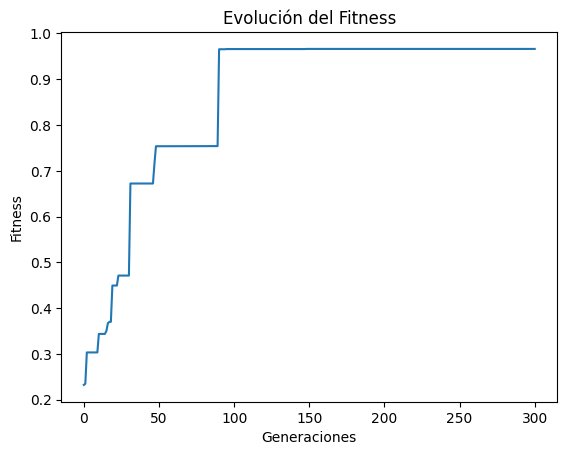

mejor fitness: 0.966225
mejor individuo: [11, 13, 13, 17, 12, 11, 12, 17, 11, 13, 13, 12, 11, 17, 17, 13, 17, 17, 17, 11]


In [ ]:
best_ts = df_gen2.loc[0,'tasa_mut']
best_mut = df_gen2.loc[0,'mutacion']

poblacion_inicial =  init_population(POPSIZE, chromo_size)
best_ind, bestfitness = genetic_algorithm(poblacion_inicial, ItemPool, GENERATIONS, best_ts, BIN_CAP,
                                          crossover=best_xover, mutation=best_mut,
                                          selection_parents_method = best_sel,
                                          selection_survivors_method = 'ranking')
plt.plot(bestfitness)
plt.title("Evolución del Fitness")
plt.xlabel("Generaciones")
plt.ylabel("Fitness")
plt.show()

# Resultados
print("mejor fitness:", best_ind.fitness)
print("mejor individuo:", best_ind.chromosome)

In [ ]:
# Solución
dict_temp = {k: v for k, v in zip(range(chromo_size), [ [] for _ in range(chromo_size) ] )}
dict_bin = deepcopy(dict_temp)
for itm, bin in enumerate(best_ind.chromosome):
  dict_temp[bin].append(itemsize[itm])
for itm, bin in enumerate(best_ind.chromosome):
  dict_bin[itm].append(dict_temp[itm])
  dict_bin[itm].append(sum(dict_temp[itm]))
bin_list = sorted(dict_bin.items(), key=lambda item: item[1][1], reverse=True)
bin_sol =  {}
for i, bin in enumerate(bin_list):
  if bin[1][1]==0:
    break
  bin_sol[i]=bin[1]

df_sol = pd.DataFrame(columns=['Bin', 'Items_size', 'Capacidad_Ocupada', 'Capacidad_Total'])
bin_list = list(bin_sol.keys())
for i in range(len(bin_sol)):
    df_sol.loc[i,'Bin'] = bin_list[i]
    df_sol.loc[i,'Items_size'] = list(bin_sol[i][0])
    df_sol.loc[i,'Capacidad_Ocupada'] = bin_sol[i][1]
    df_sol.loc[i,'Capacidad_Total'] = BIN_CAP

df_sol = df_sol.set_index('Bin')

print('Numero de items:', len(itemsize))
print('Items (tamaño):', itemsize)
display(df_sol)

Numero de items: 40
Items (tamaño): [12, 27, 41, 29, 24, 31, 26, 2, 9, 3, 5, 43, 5, 2, 2, 24, 14, 40, 11, 43, 34, 5, 33, 45, 12, 38, 36, 46, 3, 42, 12, 11, 6, 18, 7, 29, 43, 36, 39, 47]


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[12, 31, 9, 5, 43]",100,100
1,"[27, 41, 3, 5, 24]",100,100
2,"[29, 2, 2, 2, 14, 40, 11]",100,100
3,"[24, 26, 43]",93,100


PRUEBA CON SOLUCION EXACTA

,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[9, 1]",10,10
1,"[2, 1, 2, 2, 1, 1, 1]",10,10
2,"[6, 4]",10,10
3,"[8, 1, 1]",10,10
4,"[1, 1, 7, 1]",10,10


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 5 BIN_CAP: 10 ITEM_NUM: 18
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 18
Max. tamaño item: 9
Items (tamaño): [9, 1, 2, 1, 2, 2, 1, 1, 1, 6, 4, 8, 1, 1, 1, 1, 7, 1]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 18
Poblacion inicial, best_fitness = 0.372
generacion 0, (Mejor fitness = 0.4422222222222222)
generacion 10, (Mejor fitness = 0.49500000000000005)
generacion 20, (Mejor fitness = 0.6)
generacion 30, (Mejor fitness = 0.6257142857142857)
generacion 40, (Mejor fitness = 0.8033333333333333)
generacion 50, (Mejor fitness = 0.8033333333333333)
generacion 60, (Mejor fitness = 1.0)
generacion 70, (Mejor fitness = 1.0)
generaci

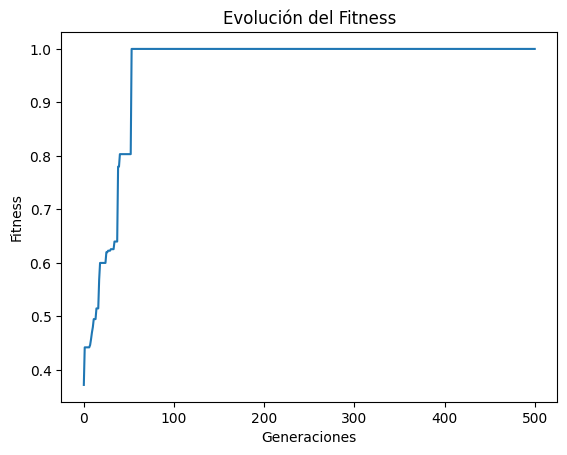

mejor fitness: 1.0
mejor individuo: [3, 3, 1, 14, 1, 0, 12, 0, 0, 1, 0, 14, 12, 14, 0, 12, 12, 0]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 18
Items (tamaño): [9, 1, 2, 1, 2, 2, 1, 1, 1, 6, 4, 8, 1, 1, 1, 1, 7, 1]
Número de bins: 5
Número de bins-full: 5
Número de bins-nofull: 0
Capacidad No Ocupada: 0
Número de bins que exceden capacidad: 0


,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[2, 1, 1, 4, 1, 1]",10,10,0,True,False
1,"[2, 2, 6]",10,10,0,True,False
2,"[9, 1]",10,10,0,True,False
3,"[1, 1, 1, 7]",10,10,0,True,False
4,"[1, 8, 1]",10,10,0,True,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[15, 11, 4, 6, 1, 3]",40,40
1,"[15, 25]",40,40
2,"[6, 26, 6, 1, 1]",40,40
3,"[32, 5, 2, 1]",40,40
4,"[34, 3, 2, 1]",40,40


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 5 BIN_CAP: 40 ITEM_NUM: 21
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 21
Max. tamaño item: 34
Items (tamaño): [15, 11, 4, 6, 1, 3, 15, 25, 6, 26, 6, 1, 1, 32, 5, 2, 1, 34, 3, 2, 1]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 21
Poblacion inicial, best_fitness = 0.2660576923076923
generacion 0, (Mejor fitness = 0.3128125)
generacion 10, (Mejor fitness = 0.43097222222222226)
generacion 20, (Mejor fitness = 0.5075000000000001)
generacion 30, (Mejor fitness = 0.6223214285714286)
generacion 40, (Mejor fitness = 0.7533333333333333)
generacion 50, (Mejor fitness = 0.7604166666666666)
generacion 60, (Mejor fitness = 0.761875)
gene

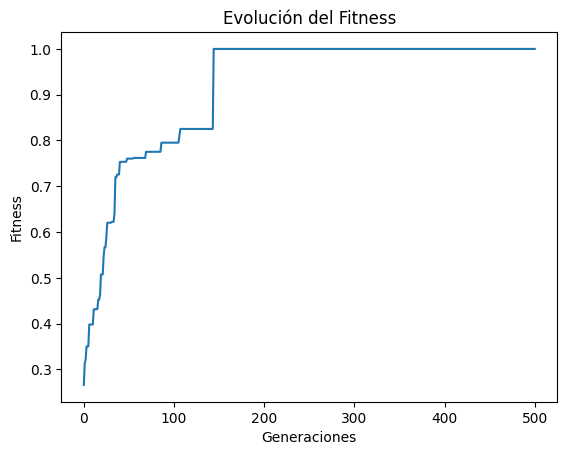

mejor fitness: 1.0
mejor individuo: [20, 2, 14, 20, 9, 20, 20, 12, 9, 2, 12, 2, 12, 9, 12, 14, 9, 14, 12, 2, 20]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 21
Items (tamaño): [15, 11, 4, 6, 1, 3, 15, 25, 6, 26, 6, 1, 1, 32, 5, 2, 1, 34, 3, 2, 1]
Número de bins: 5
Número de bins-full: 5
Número de bins-nofull: 0
Capacidad No Ocupada: 0
Número de bins que exceden capacidad: 0


,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[11, 26, 1, 2]",40,40,0,True,False
1,"[1, 6, 32, 1]",40,40,0,True,False
2,"[25, 6, 1, 5, 3]",40,40,0,True,False
3,"[4, 2, 34]",40,40,0,True,False
4,"[15, 6, 3, 15, 1]",40,40,0,True,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[5, 62, 1, 1, 1]",70,70
1,"[55, 2, 6, 4, 2, 1]",70,70
2,"[51, 5, 7, 5, 1, 1]",70,70
3,"[13, 26, 28, 3]",70,70
4,"[10, 24, 3, 23, 7, 2, 1]",70,70


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 5 BIN_CAP: 70 ITEM_NUM: 28
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 28
Max. tamaño item: 62
Items (tamaño): [5, 62, 1, 1, 1, 55, 2, 6, 4, 2, 1, 51, 5, 7, 5, 1, 1, 13, 26, 28, 3, 10, 24, 3, 23, 7, 2, 1]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 28
Poblacion inicial, best_fitness = 0.2014030612244898
generacion 0, (Mejor fitness = 0.22076190476190483)
generacion 10, (Mejor fitness = 0.32805194805194804)
generacion 20, (Mejor fitness = 0.3975918367346939)
generacion 30, (Mejor fitness = 0.5497448979591837)
generacion 40, (Mejor fitness = 0.718843537414966)
generacion 50, (Mejor fitness = 0.7666666666666666)
generacion 60,

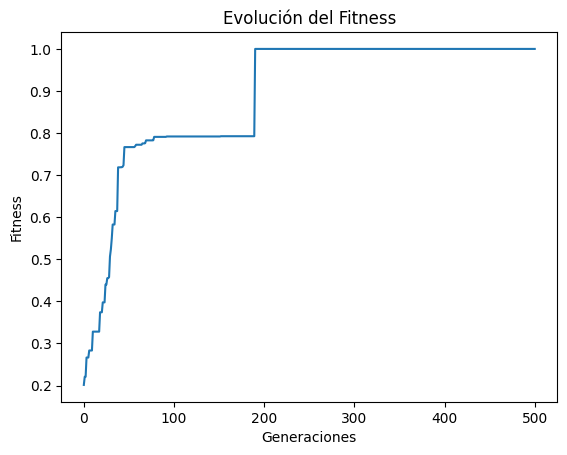

mejor fitness: 1.0
mejor individuo: [25, 2, 14, 2, 25, 14, 17, 17, 3, 2, 25, 25, 25, 14, 25, 25, 25, 3, 17, 3, 17, 17, 3, 2, 17, 14, 2, 3]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 28
Items (tamaño): [5, 62, 1, 1, 1, 55, 2, 6, 4, 2, 1, 51, 5, 7, 5, 1, 1, 13, 26, 28, 3, 10, 24, 3, 23, 7, 2, 1]
Número de bins: 5
Número de bins-full: 5
Número de bins-nofull: 0
Capacidad No Ocupada: 0
Número de bins que exceden capacidad: 0


,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[62, 1, 2, 3, 2]",70,70,0,True,False
1,"[4, 13, 28, 24, 1]",70,70,0,True,False
2,"[1, 55, 7, 7]",70,70,0,True,False
3,"[2, 6, 26, 3, 10, 23]",70,70,0,True,False
4,"[5, 1, 1, 51, 5, 5, 1, 1]",70,70,0,True,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[91, 5, 3, 1]",100,100
1,"[44, 14, 36, 3, 2, 1]",100,100
2,"[23, 8, 26, 23, 19, 1]",100,100
3,"[92, 1, 1, 3, 1, 2]",100,100
4,"[83, 17]",100,100


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 5 BIN_CAP: 100 ITEM_NUM: 24
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 24
Max. tamaño item: 92
Items (tamaño): [91, 5, 3, 1, 44, 14, 36, 3, 2, 1, 23, 8, 26, 23, 19, 1, 92, 1, 1, 3, 1, 2, 83, 17]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 24
Poblacion inicial, best_fitness = 0.27089230769230765
generacion 0, (Mejor fitness = 0.27089230769230765)
generacion 10, (Mejor fitness = 0.35443636363636366)
generacion 20, (Mejor fitness = 0.5424)
generacion 30, (Mejor fitness = 0.6555142857142858)
generacion 40, (Mejor fitness = 0.7676666666666666)
generacion 50, (Mejor fitness = 0.7726000000000001)
generacion 60, (Mejor fitness = 0

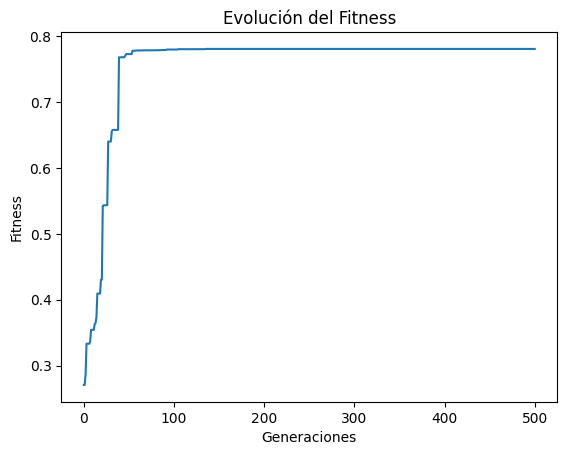

mejor fitness: 0.7804333333333334
mejor individuo: [5, 5, 0, 0, 18, 9, 22, 0, 9, 5, 22, 22, 22, 18, 6, 0, 0, 22, 22, 22, 9, 22, 9, 18]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 24
Items (tamaño): [91, 5, 3, 1, 44, 14, 36, 3, 2, 1, 23, 8, 26, 23, 19, 1, 92, 1, 1, 3, 1, 2, 83, 17]
Número de bins: 6
Número de bins-full: 3
Número de bins-nofull: 3
Capacidad No Ocupada: 100
Número de bins que exceden capacidad: 0


,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[3, 1, 3, 1, 92]",100,100,0,True,False
1,"[14, 2, 1, 83]",100,100,0,True,False
2,"[36, 23, 8, 26, 1, 1, 3, 2]",100,100,0,True,False
3,"[91, 5, 1]",97,100,3,False,False
4,"[44, 23, 17]",84,100,16,False,False
5,[19],19,100,81,False,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,[10],10,10
1,[10],10,10
2,"[5, 1, 1, 1, 2]",10,10
3,"[7, 2, 1]",10,10
4,"[8, 1, 1]",10,10
5,[10],10,10
6,[10],10,10
7,"[8, 1, 1]",10,10
8,"[1, 9]",10,10


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 10 BIN_CAP: 10 ITEM_NUM: 22
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 22
Max. tamaño item: 10
Items (tamaño): [10, 10, 5, 1, 1, 1, 2, 7, 2, 1, 8, 1, 1, 10, 10, 8, 1, 1, 1, 9, 3, 7]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 22
Poblacion inicial, best_fitness = 0.24833333333333332
generacion 0, (Mejor fitness = 0.52)
generacion 10, (Mejor fitness = 0.6)
generacion 20, (Mejor fitness = 0.7015384615384617)
generacion 30, (Mejor fitness = 0.7816666666666667)
generacion 40, (Mejor fitness = 0.8563636363636363)
generacion 50, (Mejor fitness = 0.8927272727272727)
generacion 60, (Mejor fitness = 0.8927272727272727)
generacion 70

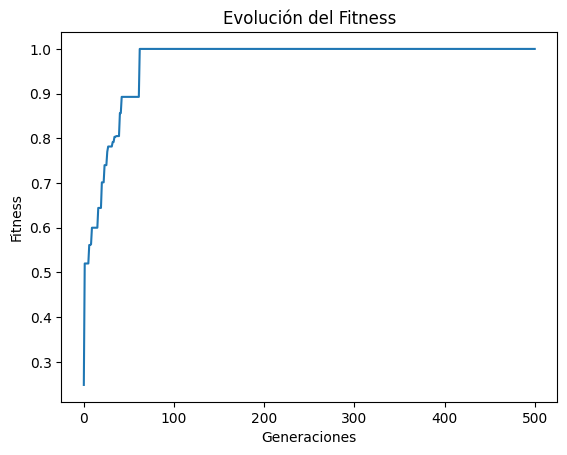

mejor fitness: 1.0
mejor individuo: [20, 4, 19, 7, 19, 3, 15, 3, 8, 3, 8, 12, 3, 18, 10, 15, 7, 7, 19, 12, 19, 7]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 22
Items (tamaño): [10, 10, 5, 1, 1, 1, 2, 7, 2, 1, 8, 1, 1, 10, 10, 8, 1, 1, 1, 9, 3, 7]
Número de bins: 10
Número de bins-full: 10
Número de bins-nofull: 0
Capacidad No Ocupada: 0
Número de bins que exceden capacidad: 0


,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[1, 7, 1, 1]",10,10,0,True,False
1,[10],10,10,0,True,False
2,"[1, 1, 1, 7]",10,10,0,True,False
3,"[2, 8]",10,10,0,True,False
4,[10],10,10,0,True,False
5,"[1, 9]",10,10,0,True,False
6,"[2, 8]",10,10,0,True,False
7,[10],10,10,0,True,False
8,"[5, 1, 1, 3]",10,10,0,True,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[33, 3, 3, 1]",40,40
1,"[21, 15, 2, 2]",40,40
2,[40],40,40
3,"[16, 8, 11, 5]",40,40
4,"[17, 23]",40,40
5,"[38, 2]",40,40
6,"[24, 3, 7, 3, 1, 1, 1]",40,40
7,"[31, 9]",40,40
8,"[2, 16, 12, 8, 1, 1]",40,40


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 10 BIN_CAP: 40 ITEM_NUM: 35
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 35
Max. tamaño item: 40
Items (tamaño): [33, 3, 3, 1, 21, 15, 2, 2, 40, 16, 8, 11, 5, 17, 23, 38, 2, 24, 3, 7, 3, 1, 1, 1, 31, 9, 2, 16, 12, 8, 1, 1, 31, 7, 2]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 35
Poblacion inicial, best_fitness = 0.2828260869565218
generacion 0, (Mejor fitness = 0.3609375)
generacion 10, (Mejor fitness = 0.41381944444444446)
generacion 20, (Mejor fitness = 0.49046874999999995)
generacion 30, (Mejor fitness = 0.5603333333333335)
generacion 40, (Mejor fitness = 0.647142857142857)
generacion 50, (Mejor fitness = 0.73687500000000

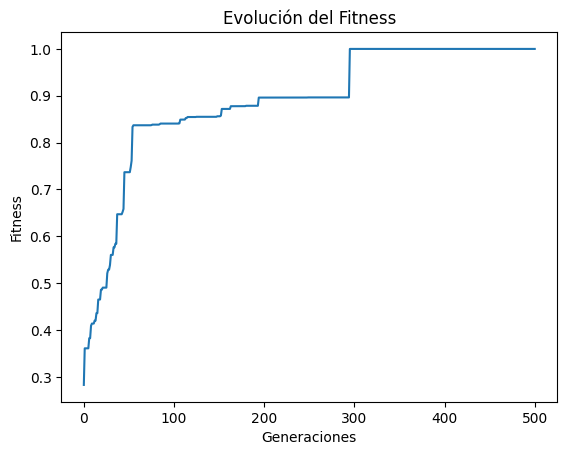

mejor fitness: 1.0
mejor individuo: [14, 4, 4, 24, 34, 34, 10, 23, 32, 18, 27, 11, 11, 23, 27, 10, 34, 11, 27, 14, 27, 34, 34, 18, 24, 23, 4, 18, 23, 24, 4, 27, 4, 18, 27]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 35
Items (tamaño): [33, 3, 3, 1, 21, 15, 2, 2, 40, 16, 8, 11, 5, 17, 23, 38, 2, 24, 3, 7, 3, 1, 1, 1, 31, 9, 2, 16, 12, 8, 1, 1, 31, 7, 2]
Número de bins: 10
Número de bins-full: 10
Número de bins-nofull: 0
Capacidad No Ocupada: 0
Número de bins que exceden capacidad: 0


,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[3, 3, 2, 1, 31]",40,40,0,True,False
1,"[2, 38]",40,40,0,True,False
2,"[11, 5, 24]",40,40,0,True,False
3,"[33, 7]",40,40,0,True,False
4,"[16, 1, 16, 7]",40,40,0,True,False
5,"[2, 17, 9, 12]",40,40,0,True,False
6,"[1, 31, 8]",40,40,0,True,False
7,"[8, 23, 3, 3, 1, 2]",40,40,0,True,False
8,[40],40,40,0,True,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[39, 24, 1, 1, 4, 1]",70,70
1,"[54, 1, 3, 1, 3, 1, 6, 1]",70,70
2,"[10, 10, 45, 2, 3]",70,70
3,"[63, 3, 2, 1, 1]",70,70
4,"[47, 8, 4, 10, 1]",70,70
5,"[28, 17, 10, 3, 1, 7, 2, 1, 1]",70,70
6,"[18, 47, 1, 3, 1]",70,70
7,"[51, 18, 1]",70,70
8,"[35, 15, 4, 13, 1, 1, 1]",70,70


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 10 BIN_CAP: 70 ITEM_NUM: 58
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 58
Max. tamaño item: 63
Items (tamaño): [39, 24, 1, 1, 4, 1, 54, 1, 3, 1, 3, 1, 6, 1, 10, 10, 45, 2, 3, 63, 3, 2, 1, 1, 47, 8, 4, 10, 1, 28, 17, 10, 3, 1, 7, 2, 1, 1, 18, 47, 1, 3, 1, 51, 18, 1, 35, 15, 4, 13, 1, 1, 1, 20, 20, 23, 6, 1]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 58
Poblacion inicial, best_fitness = 0.18307977736549164
generacion 0, (Mejor fitness = 0.18977190876350544)
generacion 10, (Mejor fitness = 0.23091458805744516)
generacion 20, (Mejor fitness = 0.24373393801965224)
generacion 30, (Mejor fitness = 0.29984693877551016)
generacion

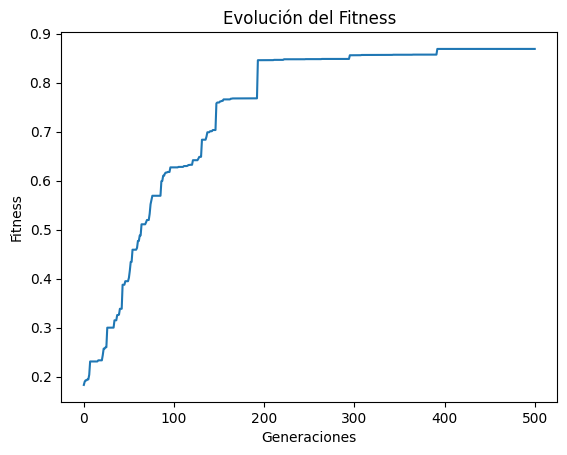

mejor fitness: 0.8685714285714287
mejor individuo: [5, 53, 40, 3, 40, 5, 40, 18, 28, 18, 40, 53, 33, 18, 23, 28, 14, 3, 28, 3, 40, 28, 40, 18, 56, 23, 14, 53, 28, 5, 56, 28, 28, 3, 33, 14, 3, 14, 18, 18, 56, 40, 18, 33, 23, 40, 53, 28, 14, 14, 3, 3, 14, 23, 15, 28, 33, 56]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 58
Items (tamaño): [39, 24, 1, 1, 4, 1, 54, 1, 3, 1, 3, 1, 6, 1, 10, 10, 45, 2, 3, 63, 3, 2, 1, 1, 47, 8, 4, 10, 1, 28, 17, 10, 3, 1, 7, 2, 1, 1, 18, 47, 1, 3, 1, 51, 18, 1, 35, 15, 4, 13, 1, 1, 1, 20, 20, 23, 6, 1]
Número de bins: 11
Número de bins-full: 7
Número de bins-nofull: 4
Capacidad No Ocupada: 70
Número de bins que exceden capacidad: 0


,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[1, 2, 63, 1, 1, 1, 1]",70,70,0,True,False
1,"[45, 4, 2, 1, 4, 13, 1]",70,70,0,True,False
2,"[1, 1, 1, 1, 18, 47, 1]",70,70,0,True,False
3,"[3, 10, 3, 2, 1, 10, 3, 15, 23]",70,70,0,True,False
4,"[6, 7, 51, 6]",70,70,0,True,False
5,"[1, 4, 54, 3, 3, 1, 3, 1]",70,70,0,True,False
6,"[24, 1, 10, 35]",70,70,0,True,False
7,"[39, 1, 28]",68,70,2,False,False
8,"[47, 17, 1, 1]",66,70,4,False,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[15, 10, 16, 31, 8, 18, 1, 1]",100,100
1,"[25, 73, 2]",100,100
2,"[64, 35, 1]",100,100
3,"[76, 6, 17, 1]",100,100
4,"[11, 6, 64, 4, 13, 2]",100,100
5,"[19, 12, 11, 32, 10, 9, 3, 1, 3]",100,100
6,"[79, 7, 6, 1, 2, 2, 2, 1]",100,100
7,"[91, 8, 1]",100,100
8,"[68, 10, 5, 9, 3, 5]",100,100


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 10 BIN_CAP: 100 ITEM_NUM: 55
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 55
Max. tamaño item: 91
Items (tamaño): [15, 10, 16, 31, 8, 18, 1, 1, 25, 73, 2, 64, 35, 1, 76, 6, 17, 1, 11, 6, 64, 4, 13, 2, 19, 12, 11, 32, 10, 9, 3, 1, 3, 79, 7, 6, 1, 2, 2, 2, 1, 91, 8, 1, 68, 10, 5, 9, 3, 5, 74, 17, 6, 2, 1]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 55
Poblacion inicial, best_fitness = 0.19183125
generacion 0, (Mejor fitness = 0.19309375)
generacion 10, (Mejor fitness = 0.23642758620689652)
generacion 20, (Mejor fitness = 0.25957142857142856)
generacion 30, (Mejor fitness = 0.3687714285714286)
generacion 40, (Mejor fitness = 0.

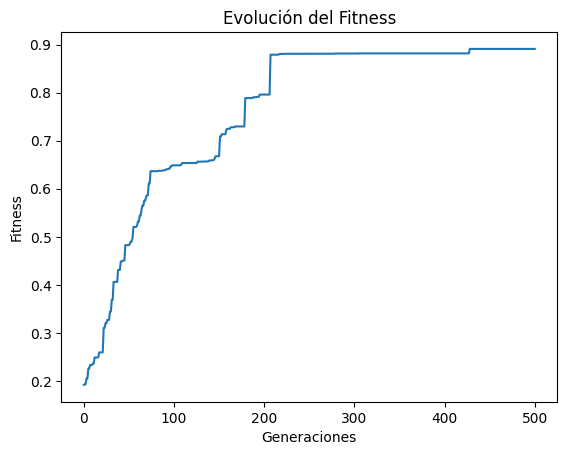

mejor fitness: 0.8909636363636363
mejor individuo: [24, 24, 34, 53, 53, 49, 18, 11, 11, 49, 8, 42, 53, 42, 18, 8, 11, 24, 11, 42, 24, 8, 11, 34, 45, 42, 53, 11, 42, 46, 34, 34, 28, 45, 42, 53, 8, 45, 34, 53, 24, 46, 28, 11, 8, 8, 18, 8, 24, 53, 34, 18, 24, 34, 18]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 55
Items (tamaño): [15, 10, 16, 31, 8, 18, 1, 1, 25, 73, 2, 64, 35, 1, 76, 6, 17, 1, 11, 6, 64, 4, 13, 2, 19, 12, 11, 32, 10, 9, 3, 1, 3, 79, 7, 6, 1, 2, 2, 2, 1, 91, 8, 1, 68, 10, 5, 9, 3, 5, 74, 17, 6, 2, 1]
Número de bins: 11
Número de bins-full: 8
Número de bins-nofull: 3
Capacidad No Ocupada: 100
Número de bins que exceden capacidad: 0


,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[2, 6, 4, 1, 68, 10, 9]",100,100,0,True,False
1,"[1, 25, 17, 11, 13, 32, 1]",100,100,0,True,False
2,"[1, 76, 5, 17, 1]",100,100,0,True,False
3,"[15, 10, 1, 64, 1, 3, 6]",100,100,0,True,False
4,"[16, 2, 3, 1, 2, 74, 2]",100,100,0,True,False
5,"[64, 1, 6, 12, 10, 7]",100,100,0,True,False
6,"[19, 79, 2]",100,100,0,True,False
7,"[9, 91]",100,100,0,True,False
8,"[31, 8, 35, 11, 6, 2, 5]",98,100,2,False,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[6, 1, 3]",10,10
1,"[5, 1, 2, 2]",10,10
2,"[7, 3]",10,10
3,"[5, 2, 1, 1, 1]",10,10
4,"[5, 2, 2, 1]",10,10
5,"[7, 1, 2]",10,10
6,"[5, 3, 1, 1]",10,10
7,"[4, 3, 1, 2]",10,10
8,"[1, 2, 5, 2]",10,10


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 20 BIN_CAP: 10 ITEM_NUM: 63
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 63
Max. tamaño item: 10
Items (tamaño): [6, 1, 3, 5, 1, 2, 2, 7, 3, 5, 2, 1, 1, 1, 5, 2, 2, 1, 7, 1, 2, 5, 3, 1, 1, 4, 3, 1, 2, 1, 2, 5, 2, 8, 2, 8, 1, 1, 1, 2, 5, 1, 1, 8, 2, 4, 6, 8, 2, 4, 6, 3, 4, 2, 1, 8, 2, 1, 1, 6, 1, 1, 10]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 63
Poblacion inicial, best_fitness = 0.18276315789473677
generacion 0, (Mejor fitness = 0.18276315789473677)
generacion 10, (Mejor fitness = 0.3805263157894736)
generacion 20, (Mejor fitness = 0.45818181818181813)
generacion 30, (Mejor fitness = 0.5299999999999999)
generacion 40, (Me

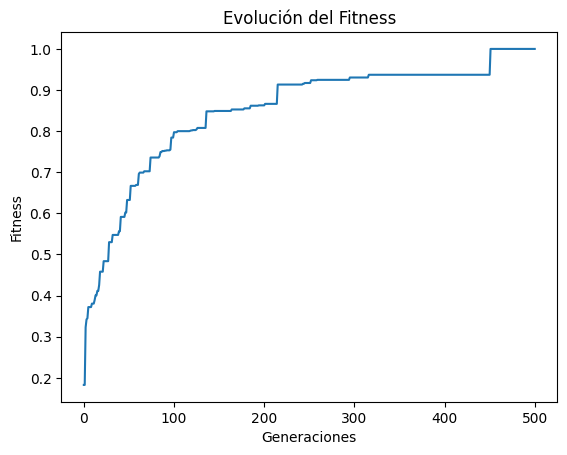

mejor fitness: 1.0
mejor individuo: [43, 28, 46, 21, 12, 37, 5, 12, 5, 37, 6, 48, 43, 37, 62, 15, 12, 1, 1, 43, 24, 18, 11, 11, 43, 46, 62, 46, 7, 28, 46, 21, 24, 15, 58, 6, 9, 34, 5, 62, 18, 34, 48, 34, 28, 9, 11, 7, 1, 9, 48, 24, 5, 24, 48, 58, 37, 48, 9, 28, 24, 43, 35]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 63
Items (tamaño): [6, 1, 3, 5, 1, 2, 2, 7, 3, 5, 2, 1, 1, 1, 5, 2, 2, 1, 7, 1, 2, 5, 3, 1, 1, 4, 3, 1, 2, 1, 2, 5, 2, 8, 2, 8, 1, 1, 1, 2, 5, 1, 1, 8, 2, 4, 6, 8, 2, 4, 6, 3, 4, 2, 1, 8, 2, 1, 1, 6, 1, 1, 10]
Número de bins: 20
Número de bins-full: 20
Número de bins-nofull: 0
Capacidad No Ocupada: 0
Número de bins que exceden capacidad: 0


,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[1, 7, 2]",10,10,0,True,False
1,"[2, 3, 1, 4]",10,10,0,True,False
2,"[2, 8]",10,10,0,True,False
3,"[2, 8]",10,10,0,True,False
4,"[1, 4, 4, 1]",10,10,0,True,False
5,"[3, 1, 6]",10,10,0,True,False
6,"[1, 7, 2]",10,10,0,True,False
7,"[2, 8]",10,10,0,True,False
8,"[5, 5]",10,10,0,True,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[26, 10, 4]",40,40
1,"[16, 24]",40,40
2,"[29, 7, 2, 2]",40,40
3,"[3, 33, 4]",40,40
4,"[34, 6]",40,40
5,"[20, 17, 1, 1, 1]",40,40
6,"[1, 36, 2, 1]",40,40
7,"[1, 31, 2, 5, 1]",40,40
8,"[20, 1, 18, 1]",40,40


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 20 BIN_CAP: 40 ITEM_NUM: 74
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 74
Max. tamaño item: 40
Items (tamaño): [26, 10, 4, 16, 24, 29, 7, 2, 2, 3, 33, 4, 34, 6, 20, 17, 1, 1, 1, 1, 36, 2, 1, 1, 31, 2, 5, 1, 20, 1, 18, 1, 26, 3, 11, 4, 35, 1, 2, 36, 1, 1, 2, 12, 17, 4, 5, 40, 30, 4, 3, 1, 1, 1, 35, 3, 2, 34, 3, 2, 1, 13, 6, 6, 1, 4, 10, 16, 15, 8, 1, 36, 3, 1]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 74
Poblacion inicial, best_fitness = 0.03399251302083332
generacion 0, (Mejor fitness = 0.03745448179271709)
generacion 10, (Mejor fitness = 0.3435795454545455)
generacion 20, (Mejor fitness = 0.40960526315789475)
generacion

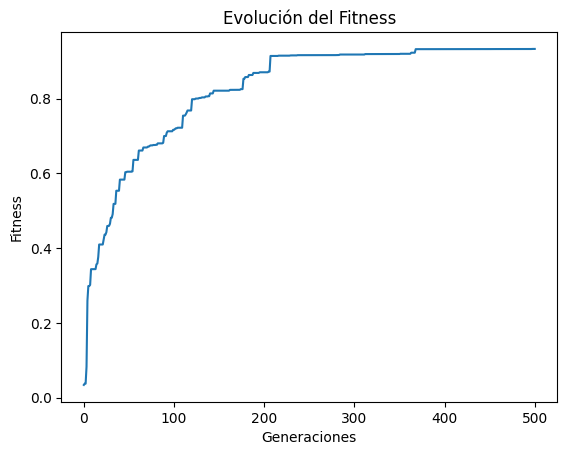

mejor fitness: 0.932797619047619
mejor individuo: [31, 35, 0, 60, 41, 10, 60, 57, 37, 21, 21, 31, 43, 31, 17, 27, 25, 31, 21, 41, 64, 27, 27, 55, 6, 55, 43, 25, 27, 31, 57, 25, 7, 10, 41, 57, 25, 6, 35, 0, 43, 61, 6, 60, 17, 56, 6, 54, 16, 35, 21, 7, 37, 6, 61, 17, 31, 55, 64, 25, 64, 7, 35, 56, 35, 41, 16, 57, 35, 10, 35, 37, 55, 35]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 74
Items (tamaño): [26, 10, 4, 16, 24, 29, 7, 2, 2, 3, 33, 4, 34, 6, 20, 17, 1, 1, 1, 1, 36, 2, 1, 1, 31, 2, 5, 1, 20, 1, 18, 1, 26, 3, 11, 4, 35, 1, 2, 36, 1, 1, 2, 12, 17, 4, 5, 40, 30, 4, 3, 1, 1, 1, 35, 3, 2, 34, 3, 2, 1, 13, 6, 6, 1, 4, 10, 16, 15, 8, 1, 36, 3, 1]
Número de bins: 21
Número de bins-full: 17
Número de bins-nofull: 4
Capacidad No Ocupada: 40
Número de bins que exceden capacidad: 0


,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[4, 36]",40,40,0,True,False
1,"[31, 1, 2, 5, 1]",40,40,0,True,False
2,"[26, 1, 13]",40,40,0,True,False
3,"[29, 3, 8]",40,40,0,True,False
4,"[30, 10]",40,40,0,True,False
5,"[20, 17, 3]",40,40,0,True,False
6,"[3, 33, 1, 3]",40,40,0,True,False
7,"[1, 1, 1, 35, 2]",40,40,0,True,False
8,"[17, 2, 1, 20]",40,40,0,True,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[9, 49, 10, 1, 1]",70,70
1,"[58, 9, 3]",70,70
2,"[34, 13, 7, 6, 2, 3, 4, 1]",70,70
3,"[18, 18, 6, 20, 2, 4, 1, 1]",70,70
4,[70],70,70
5,"[46, 22, 2]",70,70
6,"[6, 1, 57, 2, 3, 1]",70,70
7,"[53, 8, 5, 4]",70,70
8,"[60, 7, 1, 2]",70,70


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 20 BIN_CAP: 70 ITEM_NUM: 89
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 89
Max. tamaño item: 70
Items (tamaño): [9, 49, 10, 1, 1, 58, 9, 3, 34, 13, 7, 6, 2, 3, 4, 1, 18, 18, 6, 20, 2, 4, 1, 1, 70, 46, 22, 2, 6, 1, 57, 2, 3, 1, 53, 8, 5, 4, 60, 7, 1, 2, 6, 3, 10, 44, 4, 2, 1, 53, 14, 2, 1, 41, 7, 22, 52, 15, 2, 1, 39, 19, 4, 3, 2, 2, 1, 33, 9, 25, 2, 1, 56, 9, 4, 1, 20, 44, 5, 1, 41, 5, 21, 1, 2, 67, 3, 48, 22]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 89
Poblacion inicial, best_fitness = 0.037615255938440964
generacion 0, (Mejor fitness = 0.037615255938440964)
generacion 10, (Mejor fitness = 0.26107816711590304)
generacio

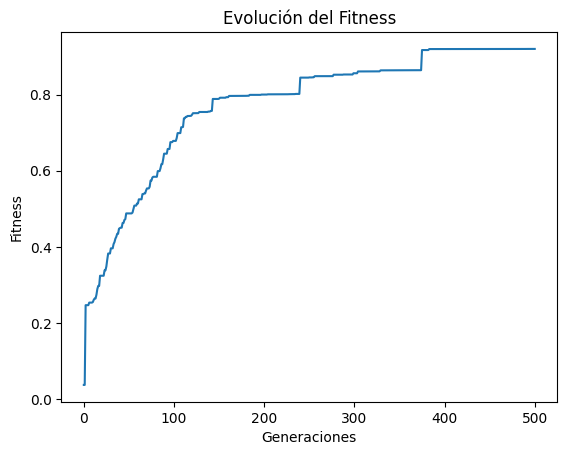

mejor fitness: 0.9199222546161321
mejor individuo: [64, 64, 41, 11, 4, 77, 41, 59, 29, 52, 63, 79, 64, 63, 79, 75, 79, 86, 11, 53, 56, 60, 24, 24, 0, 41, 63, 66, 77, 53, 21, 56, 60, 77, 75, 24, 59, 64, 56, 4, 53, 59, 75, 21, 75, 60, 52, 53, 4, 24, 63, 10, 59, 59, 24, 63, 4, 59, 66, 79, 79, 60, 11, 11, 53, 63, 56, 11, 66, 52, 56, 66, 66, 4, 77, 59, 52, 53, 52, 77, 86, 64, 11, 64, 11, 10, 56, 36, 36]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 89
Items (tamaño): [9, 49, 10, 1, 1, 58, 9, 3, 34, 13, 7, 6, 2, 3, 4, 1, 18, 18, 6, 20, 2, 4, 1, 1, 70, 46, 22, 2, 6, 1, 57, 2, 3, 1, 53, 8, 5, 4, 60, 7, 1, 2, 6, 3, 10, 44, 4, 2, 1, 53, 14, 2, 1, 41, 7, 22, 52, 15, 2, 1, 39, 19, 4, 3, 2, 2, 1, 33, 9, 25, 2, 1, 56, 9, 4, 1, 20, 44, 5, 1, 41, 5, 21, 1, 2, 67, 3, 48, 22]
Número de bins: 21
Número de bins-full: 13
Número de bins-nofull: 8
Capacidad No Ocupada: 70
Número de bins que exceden capacidad: 0


,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,[70],70,70,0,True,False
1,"[1, 7, 1, 52, 9]",70,70,0,True,False
2,"[1, 6, 4, 3, 33, 21, 2]",70,70,0,True,False
3,"[1, 1, 8, 53, 7]",70,70,0,True,False
4,"[48, 22]",70,70,0,True,False
5,"[20, 1, 1, 2, 2, 44]",70,70,0,True,False
6,"[2, 2, 60, 1, 2, 3]",70,70,0,True,False
7,"[4, 3, 44, 19]",70,70,0,True,False
8,"[7, 3, 22, 14, 22, 2]",70,70,0,True,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[19, 51, 5, 16, 3, 2, 1, 2, 1]",100,100
1,"[56, 38, 5, 1]",100,100
2,"[34, 58, 1, 1, 3, 3]",100,100
3,"[47, 23, 3, 26, 1]",100,100
4,"[75, 9, 16]",100,100
5,"[33, 45, 4, 16, 2]",100,100
6,"[72, 3, 6, 14, 4, 1]",100,100
7,"[43, 32, 24, 1]",100,100
8,"[35, 55, 1, 1, 7, 1]",100,100


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 20 BIN_CAP: 100 ITEM_NUM: 115
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 115
Max. tamaño item: 94
Items (tamaño): [19, 51, 5, 16, 3, 2, 1, 2, 1, 56, 38, 5, 1, 34, 58, 1, 1, 3, 3, 47, 23, 3, 26, 1, 75, 9, 16, 33, 45, 4, 16, 2, 72, 3, 6, 14, 4, 1, 43, 32, 24, 1, 35, 55, 1, 1, 7, 1, 68, 15, 5, 2, 1, 6, 3, 94, 6, 24, 17, 15, 3, 4, 32, 1, 2, 2, 60, 35, 3, 1, 1, 16, 15, 49, 5, 4, 6, 2, 2, 1, 94, 2, 2, 2, 55, 10, 13, 9, 12, 1, 46, 10, 18, 7, 7, 11, 1, 62, 33, 4, 1, 20, 38, 5, 21, 1, 10, 3, 2, 22, 14, 50, 9, 2, 3]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 115
Poblacion inicial, best_fitness = 0.16034366197183103
generacion 0, (M

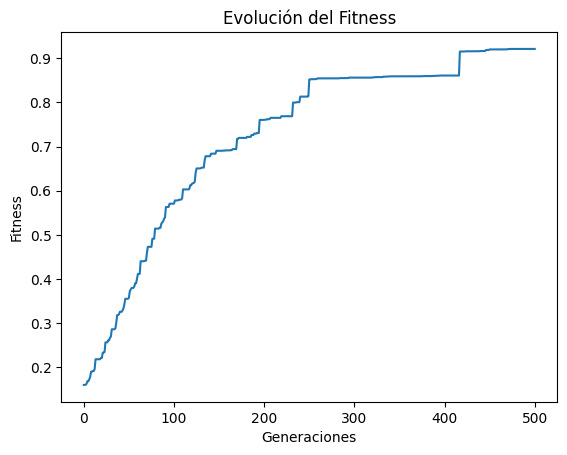

mejor fitness: 0.9211428571428572
mejor individuo: [23, 64, 87, 87, 0, 108, 12, 12, 68, 12, 23, 20, 12, 23, 27, 11, 41, 20, 11, 0, 11, 41, 27, 11, 41, 70, 98, 20, 28, 87, 70, 87, 10, 23, 41, 27, 23, 64, 11, 108, 21, 10, 24, 70, 71, 35, 87, 88, 68, 68, 68, 23, 70, 64, 70, 71, 12, 98, 28, 10, 20, 0, 24, 98, 71, 87, 87, 64, 11, 88, 20, 70, 35, 35, 68, 19, 64, 21, 68, 19, 19, 20, 68, 28, 98, 28, 11, 28, 11, 11, 0, 108, 88, 35, 88, 12, 87, 88, 24, 98, 41, 21, 108, 35, 12, 12, 88, 71, 87, 35, 41, 20, 108, 68, 20]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 115
Items (tamaño): [19, 51, 5, 16, 3, 2, 1, 2, 1, 56, 38, 5, 1, 34, 58, 1, 1, 3, 3, 47, 23, 3, 26, 1, 75, 9, 16, 33, 45, 4, 16, 2, 72, 3, 6, 14, 4, 1, 43, 32, 24, 1, 35, 55, 1, 1, 7, 1, 68, 15, 5, 2, 1, 6, 3, 94, 6, 24, 17, 15, 3, 4, 32, 1, 2, 2, 60, 35, 3, 1, 1, 16, 15, 49, 5, 4, 6, 2, 2, 1, 94, 2, 2, 2, 55, 10, 13, 9, 12, 1, 46, 10, 18, 7, 7, 11, 1, 62, 33, 4, 1,

,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[3, 47, 4, 46]",100,100,0,True,False
1,"[1, 3, 23, 1, 43, 3, 13, 12, 1]",100,100,0,True,False
2,"[5, 3, 33, 3, 1, 2, 50, 3]",100,100,0,True,False
3,"[19, 38, 34, 3, 4, 2]",100,100,0,True,False
4,"[35, 32, 33]",100,100,0,True,False
5,"[1, 3, 75, 6, 1, 14]",100,100,0,True,False
6,"[1, 68, 15, 5, 5, 2, 2, 2]",100,100,0,True,False
7,"[9, 16, 55, 1, 3, 16]",100,100,0,True,False
8,"[1, 94, 2, 3]",100,100,0,True,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[3, 3, 4]",10,10
1,"[7, 2, 1]",10,10
2,"[8, 1, 1]",10,10
3,"[9, 1]",10,10
4,"[3, 4, 1, 1, 1]",10,10
5,"[2, 2, 4, 2]",10,10
6,"[8, 1, 1]",10,10
7,"[8, 2]",10,10
8,"[7, 3]",10,10


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 50 BIN_CAP: 10 ITEM_NUM: 146
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 146
Max. tamaño item: 10
Items (tamaño): [3, 3, 4, 7, 2, 1, 8, 1, 1, 9, 1, 3, 4, 1, 1, 1, 2, 2, 4, 2, 8, 1, 1, 8, 2, 7, 3, 8, 2, 4, 3, 2, 1, 2, 7, 1, 1, 4, 3, 2, 3, 7, 8, 2, 7, 1, 2, 9, 1, 9, 1, 6, 3, 1, 4, 4, 1, 1, 10, 1, 4, 4, 1, 7, 3, 6, 2, 2, 5, 5, 6, 2, 1, 1, 5, 2, 3, 10, 1, 1, 5, 2, 1, 3, 3, 1, 1, 1, 1, 10, 9, 1, 6, 1, 3, 7, 1, 1, 1, 2, 1, 5, 2, 8, 1, 1, 2, 3, 4, 1, 7, 1, 2, 10, 10, 9, 1, 3, 7, 8, 2, 2, 5, 1, 2, 3, 6, 1, 1, 2, 1, 4, 1, 1, 5, 5, 8, 2, 4, 3, 2, 1, 5, 1, 3, 1]
***************************************************************
 ** Se inicia algoritmo genetico **
Tamaño de cromosoma: 146
Poblacion inicial, best_f

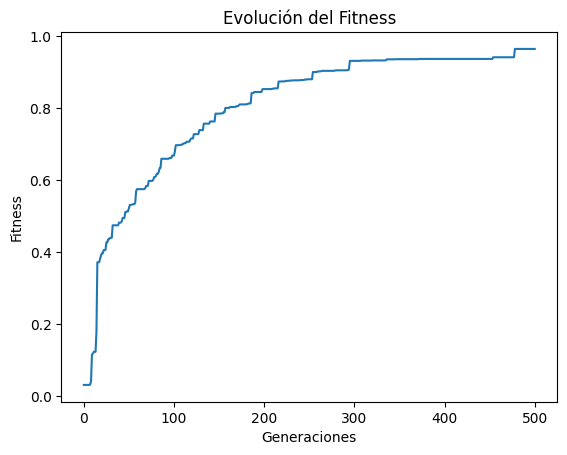

mejor fitness: 0.9650980392156864
mejor individuo: [31, 121, 59, 42, 29, 50, 74, 118, 9, 62, 34, 90, 57, 70, 88, 23, 108, 85, 51, 34, 124, 127, 50, 144, 67, 114, 102, 85, 121, 127, 105, 114, 140, 140, 4, 113, 90, 11, 136, 127, 102, 136, 128, 87, 29, 90, 26, 70, 57, 139, 118, 31, 142, 50, 26, 57, 144, 4, 125, 31, 9, 118, 118, 34, 59, 13, 121, 105, 2, 112, 5, 124, 74, 77, 112, 30, 48, 123, 142, 0, 48, 50, 87, 23, 42, 13, 11, 128, 102, 33, 77, 90, 87, 48, 51, 0, 23, 90, 48, 11, 23, 2, 51, 67, 127, 50, 26, 11, 88, 114, 117, 140, 4, 122, 75, 113, 144, 130, 130, 108, 127, 26, 105, 51, 0, 102, 142, 62, 90, 118, 5, 23, 29, 118, 88, 9, 30, 5, 50, 121, 90, 5, 140, 128, 13, 57]
***************************************************************
 ** Solución con algorimo genetico **
Número de items: 146
Items (tamaño): [3, 3, 4, 7, 2, 1, 8, 1, 1, 9, 1, 3, 4, 1, 1, 1, 2, 2, 4, 2, 8, 1, 1, 8, 2, 7, 3, 8, 2, 4, 3, 2, 1, 2, 7, 1, 1, 4, 3, 2, 3, 7, 8, 2, 7, 1, 2, 9, 1, 9, 1, 6, 3, 1, 4, 4, 1, 1, 10, 1, 4, 

,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[1, 7, 2]",10,10,0,True,False
1,"[5, 5]",10,10,0,True,False
2,"[7, 1, 2]",10,10,0,True,False
3,"[6, 1, 2, 1]",10,10,0,True,False
4,"[1, 4, 5]",10,10,0,True,False
5,"[4, 1, 2, 3]",10,10,0,True,False
6,"[6, 1, 3]",10,10,0,True,False
7,"[1, 3, 1, 1, 4]",10,10,0,True,False
8,"[2, 4, 2, 2]",10,10,0,True,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[33, 6, 1]",40,40
1,"[3, 11, 11, 13, 2]",40,40
2,"[8, 7, 25]",40,40
3,"[5, 23, 11, 1]",40,40
4,"[30, 2, 4, 3, 1]",40,40
5,"[3, 6, 31]",40,40
6,"[1, 9, 25, 3, 1, 1]",40,40
7,"[17, 13, 1, 6, 2, 1]",40,40
8,"[34, 1, 1, 2, 1, 1]",40,40


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 50 BIN_CAP: 40 ITEM_NUM: 216
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 216
Max. tamaño item: 38
Items (tamaño): [33, 6, 1, 3, 11, 11, 13, 2, 8, 7, 25, 5, 23, 11, 1, 30, 2, 4, 3, 1, 3, 6, 31, 1, 9, 25, 3, 1, 1, 17, 13, 1, 6, 2, 1, 34, 1, 1, 2, 1, 1, 22, 13, 2, 3, 24, 11, 4, 1, 14, 1, 12, 3, 5, 4, 1, 12, 6, 17, 5, 35, 3, 1, 1, 6, 3, 25, 1, 4, 1, 14, 7, 12, 4, 2, 1, 33, 5, 1, 1, 2, 22, 15, 1, 38, 2, 4, 27, 6, 3, 27, 12, 1, 32, 1, 4, 1, 2, 15, 15, 1, 4, 3, 2, 8, 18, 10, 3, 1, 11, 7, 6, 11, 3, 2, 5, 19, 7, 3, 2, 3, 1, 4, 34, 1, 1, 37, 1, 2, 5, 7, 12, 9, 7, 2, 38, 38, 2, 19, 3, 16, 2, 26, 1, 4, 8, 1, 37, 1, 2, 34, 4, 1, 1, 36, 4, 2, 13, 8, 15, 1, 1, 6, 15, 8, 7, 2, 2, 7, 26, 4, 1, 2, 2, 19, 7, 12, 19, 5

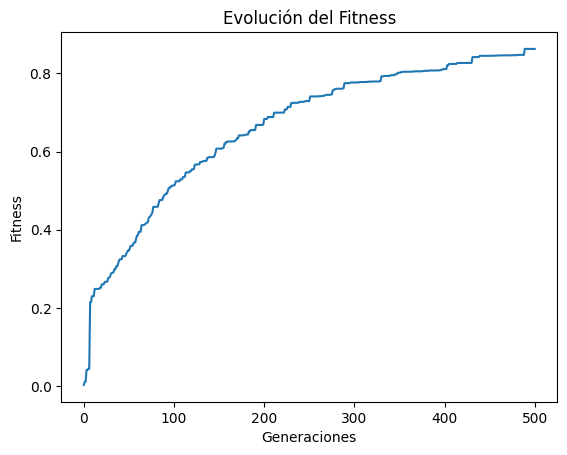

mejor fitness: 0.8625
mejor individuo: [213, 81, 165, 63, 85, 171, 151, 119, 17, 85, 166, 6, 118, 65, 63, 107, 54, 165, 207, 180, 72, 107, 68, 112, 171, 32, 30, 145, 119, 165, 29, 68, 17, 152, 210, 30, 100, 68, 152, 176, 30, 210, 63, 180, 105, 196, 32, 22, 63, 62, 65, 150, 152, 54, 3, 105, 196, 65, 138, 207, 51, 166, 150, 206, 49, 6, 105, 51, 86, 107, 10, 151, 49, 35, 112, 26, 34, 26, 32, 51, 206, 81, 161, 35, 66, 105, 119, 29, 173, 49, 35, 17, 54, 152, 66, 180, 86, 105, 26, 145, 151, 99, 118, 3, 85, 165, 187, 3, 63, 85, 10, 35, 62, 150, 161, 68, 171, 34, 63, 104, 54, 72, 139, 139, 32, 68, 75, 199, 63, 105, 54, 161, 65, 213, 105, 52, 199, 107, 49, 180, 63, 30, 180, 52, 99, 210, 206, 104, 65, 22, 86, 180, 65, 150, 72, 145, 206, 187, 118, 150, 84, 68, 187, 62, 206, 205, 85, 196, 166, 99, 65, 32, 84, 207, 6, 17, 81, 10, 161, 145, 150, 207, 173, 145, 196, 199, 22, 176, 22, 26, 54, 152, 171, 176, 138, 206, 112, 3, 166, 3, 65, 35, 207, 206, 119, 99, 187, 17, 22, 151, 17, 100, 100, 206, 145, 

,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[14, 7, 19]",40,40,0,True,False
1,"[13, 27]",40,40,0,True,False
2,"[3, 34, 1, 2]",40,40,0,True,False
3,"[33, 7]",40,40,0,True,False
4,"[6, 12, 3, 19]",40,40,0,True,False
5,"[14, 11, 15]",40,40,0,True,False
6,"[3, 1, 13, 1, 1, 3, 2, 16]",40,40,0,True,False
7,"[11, 1, 6, 9, 1, 1, 4, 7]",40,40,0,True,False
8,"[31, 1, 1, 5, 1, 1]",40,40,0,True,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[16, 31, 16, 4, 1, 2]",70,70
1,"[8, 2, 44, 13, 2, 1]",70,70
2,"[53, 11, 2, 2, 2]",70,70
3,"[62, 3, 1, 4]",70,70
4,"[64, 1, 5]",70,70
5,"[7, 42, 7, 8, 5, 1]",70,70
6,"[68, 1, 1]",70,70
7,"[40, 9, 18, 3]",70,70
8,"[61, 4, 5]",70,70


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 50 BIN_CAP: 70 ITEM_NUM: 248
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 248
Max. tamaño item: 69
Items (tamaño): [16, 31, 16, 4, 1, 2, 8, 2, 44, 13, 2, 1, 53, 11, 2, 2, 2, 62, 3, 1, 4, 64, 1, 5, 7, 42, 7, 8, 5, 1, 68, 1, 1, 40, 9, 18, 3, 61, 4, 5, 37, 12, 15, 6, 61, 1, 5, 1, 2, 11, 14, 35, 9, 1, 51, 9, 7, 3, 52, 1, 4, 12, 1, 57, 10, 3, 26, 25, 14, 4, 1, 32, 17, 1, 13, 7, 50, 3, 4, 7, 3, 3, 25, 5, 22, 4, 5, 4, 1, 4, 33, 24, 10, 1, 2, 17, 23, 10, 12, 5, 2, 1, 1, 23, 43, 2, 1, 25, 4, 40, 1, 29, 7, 25, 2, 3, 1, 2, 1, 18, 48, 1, 1, 1, 1, 23, 14, 10, 4, 10, 3, 1, 3, 2, 1, 18, 33, 7, 9, 2, 63, 7, 19, 22, 24, 3, 1, 1, 27, 18, 2, 23, 1, 19, 21, 5, 1, 12, 4, 5, 1, 1, 54, 9, 7, 47, 6, 1, 13, 3, 61, 3, 2, 1, 3

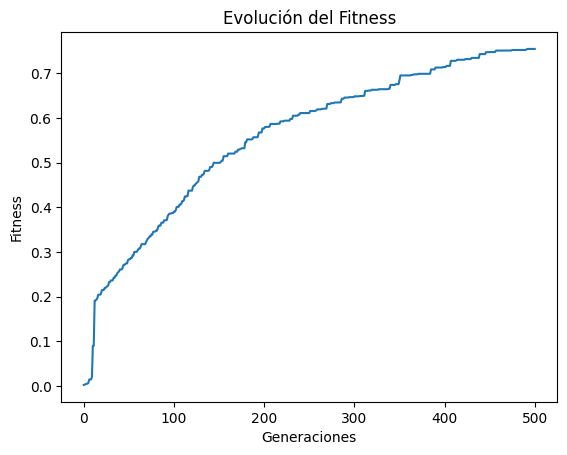

mejor fitness: 0.7542264647794602
mejor individuo: [43, 84, 31, 6, 132, 92, 6, 223, 47, 26, 143, 26, 143, 39, 173, 205, 4, 50, 176, 86, 218, 117, 202, 43, 154, 222, 8, 61, 205, 84, 98, 60, 194, 247, 80, 171, 123, 238, 117, 11, 241, 25, 46, 192, 194, 247, 39, 245, 50, 206, 123, 235, 46, 192, 87, 61, 63, 140, 115, 25, 86, 60, 206, 60, 11, 192, 5, 105, 173, 46, 12, 104, 80, 115, 139, 245, 12, 6, 12, 235, 246, 183, 16, 12, 205, 247, 46, 11, 202, 206, 43, 5, 52, 87, 43, 87, 92, 245, 46, 26, 245, 246, 117, 105, 236, 245, 80, 61, 105, 205, 35, 198, 26, 198, 192, 104, 63, 180, 245, 247, 123, 105, 43, 202, 205, 173, 236, 241, 47, 171, 61, 246, 21, 4, 180, 26, 11, 140, 171, 241, 183, 77, 140, 235, 171, 236, 47, 167, 132, 132, 236, 80, 5, 46, 241, 236, 202, 115, 192, 115, 92, 21, 206, 8, 246, 90, 90, 39, 43, 123, 21, 247, 154, 167, 171, 8, 198, 194, 176, 12, 140, 238, 16, 104, 218, 84, 92, 223, 218, 104, 26, 16, 123, 87, 5, 173, 61, 105, 13, 77, 4, 80, 238, 6, 47, 90, 61, 50, 132, 245, 143, 12, 2

,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[2, 2, 64, 2]",70,70,0,True,False
1,"[5, 10, 4, 33, 18]",70,70,0,True,False
2,"[1, 50, 4, 5, 1, 9]",70,70,0,True,False
3,"[16, 5, 33, 2, 1, 13]",70,70,0,True,False
4,"[44, 4, 1, 9, 12]",70,70,0,True,False
...,...,...,...,...,...,...
57,"[1, 4]",5,70,65,False,False
58,"[2, 3]",5,70,65,False,False
59,"[1, 1, 1, 1]",4,70,66,False,False


,Items_size,Capacidad_Ocupada,Capacidad_Total
Bin,,,
0,"[42, 39, 12, 6, 1]",100,100
1,"[95, 2, 3]",100,100
2,"[37, 57, 2, 2, 2]",100,100
3,"[42, 17, 24, 15, 2]",100,100
4,"[91, 8, 1]",100,100
5,"[32, 52, 2, 2, 2, 2, 1, 6, 1]",100,100
6,"[38, 7, 45, 2, 6, 2]",100,100
7,"[56, 28, 14, 1, 1]",100,100
8,"[68, 13, 19]",100,100


------------------------------------------------------------------------------------------------------------
BIN_NUM_EXACT: 50 BIN_CAP: 100 ITEM_NUM: 250
------------------------------------------------------------------------------------------------------------
**************************************************************
 ** Solucion exacta **
Numero de items: 250
Max. tamaño item: 97
Items (tamaño): [42, 39, 12, 6, 1, 95, 2, 3, 37, 57, 2, 2, 2, 42, 17, 24, 15, 2, 91, 8, 1, 32, 52, 2, 2, 2, 2, 1, 6, 1, 38, 7, 45, 2, 6, 2, 56, 28, 14, 1, 1, 68, 13, 19, 20, 43, 29, 5, 3, 20, 13, 28, 31, 6, 2, 75, 2, 18, 1, 3, 1, 23, 12, 6, 2, 19, 38, 31, 16, 9, 10, 33, 1, 19, 36, 35, 2, 7, 1, 81, 16, 1, 2, 72, 20, 6, 1, 1, 65, 34, 1, 22, 43, 25, 3, 5, 2, 53, 17, 23, 3, 1, 1, 1, 1, 40, 52, 5, 2, 1, 66, 7, 3, 2, 19, 2, 1, 19, 24, 16, 33, 6, 1, 1, 15, 53, 18, 1, 6, 6, 1, 12, 47, 35, 5, 1, 67, 14, 10, 8, 1, 97, 3, 92, 8, 20, 20, 56, 4, 71, 25, 1, 3, 44, 24, 23, 4, 3, 1, 1, 85, 6, 4, 1, 2, 2, 46, 39, 13, 1

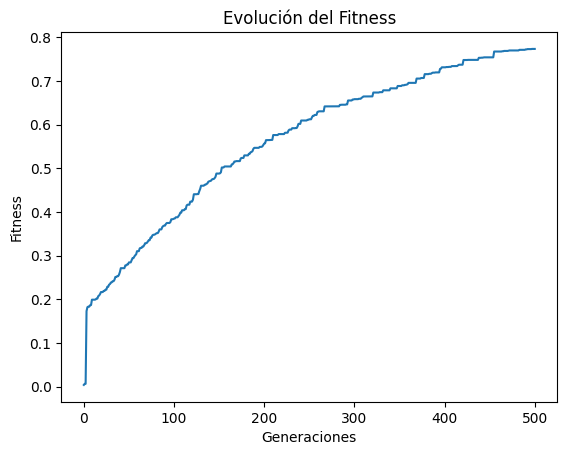

mejor fitness: 0.7732766666666667
mejor individuo: [158, 60, 138, 186, 184, 178, 43, 62, 179, 174, 119, 195, 177, 177, 5, 133, 22, 8, 94, 22, 5, 211, 9, 4, 74, 4, 41, 184, 154, 184, 41, 157, 103, 242, 22, 78, 133, 157, 103, 103, 186, 154, 112, 174, 116, 108, 142, 13, 211, 4, 174, 184, 181, 154, 103, 4, 222, 9, 153, 119, 12, 179, 140, 78, 133, 115, 62, 74, 44, 140, 147, 172, 179, 63, 41, 108, 158, 142, 6, 176, 147, 57, 242, 147, 43, 138, 116, 160, 242, 138, 211, 119, 211, 181, 15, 184, 57, 158, 13, 14, 169, 183, 184, 14, 174, 142, 74, 169, 178, 178, 140, 119, 9, 60, 43, 74, 78, 137, 41, 183, 179, 115, 137, 177, 78, 44, 133, 38, 60, 103, 153, 115, 15, 244, 183, 44, 42, 176, 43, 195, 138, 173, 62, 8, 108, 172, 157, 116, 14, 22, 103, 186, 244, 16, 160, 157, 137, 14, 186, 174, 169, 112, 160, 154, 211, 94, 160, 46, 184, 74, 179, 161, 38, 209, 142, 169, 46, 112, 12, 16, 115, 177, 195, 244, 62, 119, 242, 8, 46, 184, 209, 12, 140, 154, 244, 42, 60, 138, 138, 115, 112, 46, 181, 43, 103, 62, 63, 

,Items_size,Capacidad_Ocupada,Capacidad_Total,Capacidad_Sobrante,Bin_Full,Bin_exce_cap
Bin,,,,,,
0,"[2, 92, 4, 1, 1]",100,100,0,True,False
1,"[3, 47, 32, 18]",100,100,0,True,False
2,"[15, 8, 6, 71]",100,100,0,True,False
3,"[2, 38, 36, 24]",100,100,0,True,False
4,"[3, 38, 3, 8, 48]",100,100,0,True,False
5,"[2, 6, 1, 15, 76]",100,100,0,True,False
6,"[13, 6, 21, 39, 21]",100,100,0,True,False
7,"[2, 3, 22, 7, 64, 2]",100,100,0,True,False
8,"[24, 56, 2, 18]",100,100,0,True,False


In [ ]:
import itertools
# Dataframe con las columnas solicitas (media y std del valor de fitness)
df_compar = pd.DataFrame(columns=['BIN_NUM_EXACT', 'BIN_CAP', 'ITEM_NUM', 'MAX_ITEM_SIZE', 'fitness',
                                  'BIN_NUM_GA', 'BINS_FULL','BINS_NOFULL','CAP_NO_OCUP','BINS_EXCE_CAP'])

POPSIZE = 50        # numero de individuos
GENERATIONS = 500   # numero de generaciones

# Se generan bins (solucion exacta)
bin_num = [5, 10, 20, 50]
bin_cap = [10, 40, 70, 100]
w = 0
for bin_n in bin_num:
  for bin_c in bin_cap:
    BIN_NUM = bin_n
    BIN_CAP = bin_c
    bin_itms = {}
    for i in range(BIN_NUM):
      sum_bin_itm = 0
      bin_it = []
      while sum_bin_itm!=BIN_CAP:
        item_sz = random.randint(1,BIN_CAP-sum_bin_itm)
        bin_it.append(item_sz)
        sum_bin_itm += item_sz
      bin_itms[i] = bin_it

    bin_itms_comp = {k: v for k, v in zip(range(BIN_NUM), [ [] for _ in range(BIN_NUM) ] )}
    for itm in range(BIN_NUM):
      bin_itms_comp[itm].append(bin_itms[itm])
      bin_itms_comp[itm].append(sum(bin_itms[itm]))
    df_ini = pd.DataFrame(columns=['Bin', 'Items_size', 'Capacidad_Ocupada', 'Capacidad_Total'])

    # Se muestra solucion exacta
    bin_list = list(bin_itms_comp.keys())
    for j in range(len(bin_itms_comp)):
        df_ini.loc[j,'Bin'] = bin_list[j]
        df_ini.loc[j,'Items_size'] = list(bin_itms_comp[j][0])
        df_ini.loc[j,'Capacidad_Ocupada'] = bin_itms_comp[j][1]
        df_ini.loc[j,'Capacidad_Total'] = BIN_CAP
    df_ini = df_ini.set_index('Bin')
    display(df_ini)

    # Items generados
    itemsize = list(itertools.chain.from_iterable([x for x in df_ini['Items_size']]))
    ItemPool = [Item(x) for x in itemsize]
    num_items = len(itemsize)
    max_item = max(itemsize)
    print('------------------------------------------------------------------------------------------------------------')
    print('BIN_NUM_EXACT:',BIN_NUM,'BIN_CAP:',BIN_CAP,'ITEM_NUM:',num_items)
    print('------------------------------------------------------------------------------------------------------------')
    print('**************************************************************')
    print(' ** Solucion exacta **')
    print('Numero de items:', num_items)
    print('Max. tamaño item:', max_item)
    print('Items (tamaño):', itemsize)
    print('***************************************************************')

    # Algoritmo genetico
    max_itm_bin = np.floor(BIN_CAP/max(itemsize))
    chromo_size = num_items
    print(' ** Se inicia algoritmo genetico **')
    print("Tamaño de cromosoma:", chromo_size)
    poblacion_inicial =  init_population(POPSIZE, chromo_size)
    best_ind, bestfitness = genetic_algorithm(poblacion_inicial, ItemPool, GENERATIONS, best_ts, BIN_CAP,
                                              crossover=best_xover, mutation=best_mut,
                                              selection_parents_method = best_sel,
                                              selection_survivors_method = 'ranking')
    plt.plot(bestfitness)
    plt.title("Evolución del Fitness")
    plt.xlabel("Generaciones")
    plt.ylabel("Fitness")
    plt.show()

    # Resultados
    print("mejor fitness:", best_ind.fitness)
    print("mejor individuo:", best_ind.chromosome)

    # Solución con algoritmo genetico
    dict_temp = {k: v for k, v in zip(range(chromo_size), [ [] for _ in range(chromo_size) ] )}
    dict_bin = deepcopy(dict_temp)

    for itm, bin in enumerate(best_ind.chromosome):
      dict_temp[bin].append(itemsize[itm])
    for itm, bin in enumerate(best_ind.chromosome):
      dict_bin[itm].append(dict_temp[itm])
      dict_bin[itm].append(sum(dict_temp[itm]))
    bin_list = sorted(dict_bin.items(), key=lambda item: item[1][1], reverse=True)
    bin_sol =  {}
    for h, bin in enumerate(bin_list):
      if bin[1][1]==0:
        break
      bin_sol[h]=bin[1]

    df_sol = pd.DataFrame(columns=['Bin', 'Items_size', 'Capacidad_Ocupada', 'Capacidad_Total','Capacidad_Sobrante','Bin_Full','Bin_exce_cap'])
    bin_list = list(bin_sol.keys())
    num_bin = len(bin_sol)
    bin_sobra_cap = 0
    for l in range(num_bin):
        bin_ocup = bin_sol[l][1]
        bin_sobra =  BIN_CAP - bin_ocup
        df_sol.loc[l,'Bin'] = bin_list[l]
        df_sol.loc[l,'Items_size'] = list(bin_sol[l][0])
        df_sol.loc[l,'Capacidad_Ocupada'] = bin_ocup
        df_sol.loc[l,'Capacidad_Total'] = BIN_CAP
        df_sol.loc[l,'Capacidad_Sobrante'] = bin_sobra
        df_sol.loc[l,'Bin_Full'] = True
        if bin_sobra > 0:
          df_sol.loc[l,'Bin_Full'] = False
        bin_sobra_cap += bin_sobra
        df_sol.loc[l,'Bin_exce_cap'] = (bin_sobra<0)

    bins_full = sum(df_sol['Bin_Full'])
    bins_exce = sum(df_sol['Bin_exce_cap'])
    bins_nofull = num_bin-bins_full
    df_sol = df_sol.set_index('Bin')
    print('***************************************************************')
    print(' ** Solución con algorimo genetico **')
    print('Número de items:', num_items)
    print('Items (tamaño):', itemsize)
    print('Número de bins:', num_bin)
    print('Número de bins-full:', bins_full)
    print('Número de bins-nofull:', bins_nofull)
    print('Capacidad No Ocupada:', bin_sobra_cap)
    print('Número de bins que exceden capacidad:', bins_exce)
    display(df_sol)

    # Agrega datos del fitness por corrida
    df_compar.loc[w,'BIN_NUM_EXACT'] = BIN_NUM
    df_compar.loc[w,'BIN_CAP'] = BIN_CAP
    df_compar.loc[w,'ITEM_NUM'] = num_items
    df_compar.loc[w,'MAX_ITEM_SIZE'] = max_item
    df_compar.loc[w,'fitness'] = best_ind.fitness
    df_compar.loc[w,'BIN_NUM_GA'] = num_bin
    df_compar.loc[w,'BINS_FULL'] = bins_full
    df_compar.loc[w,'BINS_NOFULL'] = bins_nofull
    df_compar.loc[w,'CAP_NO_OCUP'] = bin_sobra_cap
    df_compar.loc[w,'BINS_EXCE_CAP'] = bins_exce
    w+=1

In [ ]:
# Comparacion de resultados con diferentes numero de items y tamaños
display(df_compar)

,BIN_NUM_EXACT,BIN_CAP,ITEM_NUM,MAX_ITEM_SIZE,fitness,BIN_NUM_GA,BINS_FULL,BINS_NOFULL,CAP_NO_OCUP,BINS_EXCE_CAP
0,5,10,18,9,1.0,5,5,0,0,0
1,5,40,21,34,1.0,5,5,0,0,0
2,5,70,28,62,1.0,5,5,0,0,0
3,5,100,24,92,0.780433,6,3,3,100,0
4,10,10,22,10,1.0,10,10,0,0,0
5,10,40,35,40,1.0,10,10,0,0,0
6,10,70,58,63,0.868571,11,7,4,70,0
7,10,100,55,91,0.890964,11,8,3,100,0
8,20,10,63,10,1.0,20,20,0,0,0
9,20,40,74,40,0.932798,21,17,4,40,0


In [ ]:
6/16

0.375